In [5]:
using QuantumOptics
using OrdinaryDiffEq
using ModelingToolkit
using LinearAlgebra
using Symbolics
using SymbolicUtils
using DifferentialEquations
using Plots

In [56]:
include("../src/indexing.jl")
include("../src/doubleSums.jl")
include("../src/averageSums.jl")
include("../src/indexedMeanfield.jl")
include("../src/indexedScale.jl")

splitSums (generic function with 5 methods)

In [7]:
# Parameters
#N = 4 #number of atoms
κ, g, Γ23, Γ13, Γ12, Ω, Δc, Δ3, N = cnumbers("κ g Γ_{23} Γ_{13} Γ_{12} Ω Δ_c Δ_3 N")

# Hilbertspace
hf = FockSpace(:cavity)
ha = NLevelSpace(Symbol(:atom),3)
h = hf ⊗ ha

# Operators
a = Destroy(h,:a)
σ(i,j) = Transition(h,Symbol("σ"),i,j)

# Indices
j_ind = Index(h,:j,N)
k_ind = Index(h,:k,N)

#define some Indexed Operators
#need only to define ops in Hamiltonian and such
#if any other operator gets evaluated, it will automaticly "upgrade" it to an indexed operator
#   with index corresponding to the index, that was used for evaluation

#Hamiltonian before Indexing: H = -Δc*a'a + sum(g*(a'*σ(1,2,i) + a*σ(2,1,i)) for i=1:N) + sum(Ω*(σ(3,1,i) + σ(1,3,i)) for i=1:N) - sum(Δ3*σ(3,3,i) for i=1:N)

σ12_j = IndexedOperator(σ(1,2),j_ind)
σ21_j = IndexedOperator(σ(2,1),j_ind)
σ31_j = IndexedOperator(σ(3,1),j_ind)
σ13_j = IndexedOperator(σ(1,3),j_ind)
σ33_j = IndexedOperator(σ(3,3),j_ind)

sum1 = IndexedSingleSum(g*(a'*σ12_j + a*σ21_j),j_ind)
sum2 = IndexedSingleSum(Ω*(σ31_j + σ13_j),j_ind)
sum3 = IndexedSingleSum(Δ3*σ33_j,j_ind)

# Hamiltonian after indexing
H = -Δc*a'a + sum1 + sum2 - sum3

(Σ(j=1:N)g*(a′*σ12j)+Σ(j=1:N)g*(a*σ21j)+-Δ_c*(a′*a)+Σ(j=1:N)Ω*(σ31j)+Σ(j=1:N)Ω*(σ13j)+Σ(j=1:N)-Δ_3*(σ33j))

In [8]:
#Jumps before Indexing: J = [a;[σ(1,2,i) for i=1:N];[σ(1,3,i) for i=1:N];[σ(2,3,i) for i=1:N]]
#Jumps now:
σ12_k = IndexedOperator(σ(1,2),k_ind)
σ13_k = IndexedOperator(σ(1,3),k_ind)
σ23_k = IndexedOperator(σ(2,3),k_ind)

J = [a,σ12_k,σ13_k,σ23_k]

# Rates (no need to iterate over the atoms, since we are using indices)
rates = [κ,Γ12,Γ13,Γ23]

4-element Vector{Sym{Parameter, Base.ImmutableDict{DataType, Any}}}:
 κ
 var"Γ_{12}"
 var"Γ_{13}"
 var"Γ_{23}"

In [9]:
σ22_k = IndexedOperator(σ(2,2),k_ind)
σ33_k = IndexedOperator(σ(3,3),k_ind)

ops = [a'a,σ22_k,σ33_k]

3-element Vector{QNumber}:
 (a′*a)
 σ22k
 σ33k

In [10]:
eqs = indexedMeanfield(ops,H,J;rates=rates) #<- constant in time (depends on complexity of hamiltonian, jumps, etc. not on number of atoms)


∂ₜ(⟨a′*a⟩) = (0 + 1im)*var"∑(j=1:N)g*⟨a*σ21j⟩" + (0 - 1im)*var"∑(j=1:N)g*⟨a′*σ12j⟩" - κ*⟨a′*a⟩
∂ₜ(⟨σ22k⟩) = var"Γ_{23}"*⟨σ33k⟩ + (0 + 1im)*g*⟨a′*σ12k⟩ + (0 - 1im)*g*⟨a*σ21k⟩ - var"Γ_{12}"*⟨σ22k⟩
∂ₜ(⟨σ33k⟩) = (0 + 1im)*Ω*⟨σ13k⟩ + (0 - 1im)*Ω*⟨σ31k⟩ - var"Γ_{13}"*⟨σ33k⟩ - var"Γ_{23}"*⟨σ33k⟩


In [11]:
eqs_expanded = cumulant_expansion(eqs,2) #<- constant time (depends on number of initial equations from meanfield)
1

1

In [40]:
me_comp_ = indexedComplete(eqs_expanded;extraIndices=[:q]) #automatically complete the system <- constant time (depends on complexity of hamiltonian, jumps, etc. not on number of atoms)
1

1

In [57]:
splitSums(me_comp_[4],5)

⟨a′*σ12k⟩ ~ ((0 + 1im)*g*(a′*a*σ33k)+(0 + 1im)*g*(σ33k)+(0 + 1im)*g*(σ22k)+(0 + 1im)*g*(a′*a*σ33k)+(0 + 1im)*g*(a′*a*σ33k)+(0 - 2im)*g*(a′*a*σ33k)+(0 + 1im)*var"∑(j=1:(1//5)*N)(j≠k)g*⟨σ21j*σ12k⟩" + (0 + 4im)*var"∑(j=1:(1//5)*N)g*⟨σ21j*σ12k⟩"+-0.5var"Γ_{12}"*(a′*σ12k)+(0 + 2im)*g*(a′*a*σ22k)+(0 + 2im)*g*(σ22k)+(0 + 2im)*g*(a′*a*σ22k)+(0 + 2im)*g*(a′*a*σ22k)+(0 - 4im)*g*(a′*a*σ22k)+(0 - 1im)*g*(a′*a)+(0 + 1im)*Ω*(a′*σ32k)+-0.5κ*(a′*σ12k)+(0 - 1im)*Δ_c*(a′*σ12k))

In [31]:
me_comp_[1].rhs

(0 + 1im)*var"∑(j=1:N)g*⟨a*σ21j⟩" + (0 - 1im)*var"∑(j=1:N)g*⟨a′*σ12j⟩" - κ*⟨a′*a⟩

In [38]:
splitSums(me_comp_[1].rhs,4)

(0 + 4im)*var"∑(j=1:(1//4)*N)g*⟨a*σ21j⟩" + (0 - 4im)*var"∑(j=1:(1//4)*N)g*⟨a′*σ12j⟩" - κ*⟨a′*a⟩

In [ ]:
scaled = scaleME(me_comp_)
1

1

In [ ]:
find_missing(scaled)

Any[]

In [ ]:
scaled.states

57-element Vector{Term{AvgSym, Nothing}}:
 ⟨a′*a⟩
 ⟨σ221⟩
 ⟨σ331⟩
 ⟨a′*σ121⟩
 ⟨σ131⟩
 ⟨a⟩
 ⟨a′*σ331⟩
 ⟨a*σ221⟩
 ⟨a′*σ321⟩
 ⟨σ121*σ212⟩
 ⟨a′*σ131⟩
 ⟨a′*σ311⟩
 ⟨σ211⟩
 ⋮
 ⟨σ321*σ312⟩
 ⟨σ131*σ332⟩
 ⟨σ131*σ132⟩
 ⟨σ131*σ312⟩
 ⟨σ131*σ222⟩
 ⟨σ131*σ232⟩
 ⟨σ311*σ222⟩
 ⟨σ311*σ232⟩
 ⟨σ311*σ332⟩
 ⟨σ311*σ132⟩
 ⟨σ321*σ322⟩
 ⟨σ311*σ312⟩

In [ ]:
me_comp = scaled
1

1

In [ ]:
#me_comp = evalME(me_comp_) #this one should go like O(N), inserts first the indices needed from equation -> O(N), and then evaluates the sums -> O(N)
#1

In [ ]:
# Build an ODESystem out of the MeanfieldEquations
@named sys = ODESystem(me_comp)

Model sys with 57 equations
States (57):
  var"⟨a′*a⟩"(t)
  var"⟨σ221⟩"(t)
  var"⟨σ331⟩"(t)
  var"⟨a′*σ121⟩"(t)
  var"⟨σ131⟩"(t)
  var"⟨a⟩"(t)
⋮
Parameters (9):
  g
  κ
  N
  var"Γ_{23}"
  var"Γ_{12}"
  var"Γ_{13}"
⋮

In [ ]:
# initial state
u0 = zeros(ComplexF64, length(me_comp))

Γ12n = 1.0
Γ23n = 20Γ12n
Γ13n = 2Γ12n
Ωn = 5Γ13n
gn = 2Γ12n
Δcn = 0.0
Δ3n = 0.0
κn = 0.5Γ12n
N_ = 5e3

# list of parameters
ps = (g, Γ23, Γ13, Γ12, Ω, Δc, Δ3, κ, N)
p0 = ps .=> (gn, Γ23n, Γ13n, Γ12n, Ωn, Δcn, Δ3n, κn, N_)
tend = 10.0/κn

prob = ODEProblem(sys,u0,(0.0,tend),p0)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 2940-element Vector{Float64}:
  0.0
  9.999999999999999e-5
  0.0006740656184675868
  0.0016434511060231124
  0.0027805948979300835
  0.004203923869991296
  0.005859854436175209
  0.007854245630290524
  0.010282211112061495
  0.012560304331585032
  0.01495990557141701
  0.017442167317008917
  0.020166494623207923
  ⋮
 19.75800223361368
 19.781027732228388
 19.80479005170876
 19.829171792121667
 19.851745936914828
 19.874998069455632
 19.89969624761868
 19.92271735427278
 19.94569301537343
 19.96936014565274
 19.993892306280546
 20.0
u: 2940-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [1.3325255661461437e-14 + 0.0im, 6.661001576794957e-10 + 0.0im, 9.98900372

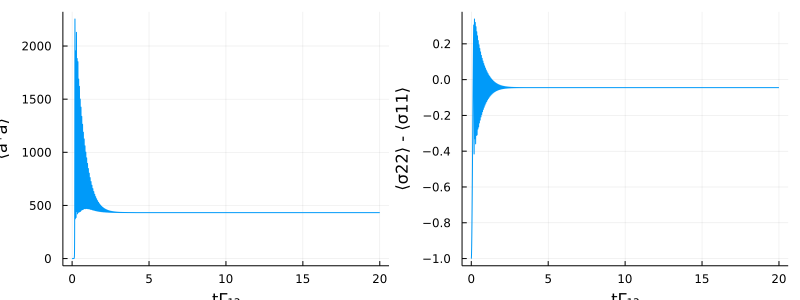

In [ ]:
n_t = real.(sol[average(a'*a)])

σ221 = NumberedOperator(σ(2,2),1)
σ331 = NumberedOperator(σ(3,3),1)

σ22m11_t = real.(2*sol[σ221] .+ sol[σ331] .-1)
#σ22m11_t = real.(2*sol[σ(2,2,1)] .+ sol[σ(3,3,1)] .-1 ) #σ11 + σ22 + σ33 = 𝟙


p1 = plot(sol.t, n_t, xlabel="tΓ₁₂", ylabel="⟨a⁺a⟩", legend = false)
p2 = plot(sol.t, σ22m11_t, xlabel="tΓ₁₂", ylabel="⟨σ22⟩ - ⟨σ11⟩", legend = false)
plot(p1, p2, layout=(1,2), size=(800,300))